In [1]:
import torch
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import NeptuneLogger, WandbLogger

In [2]:
from oml.datasets.base import DatasetQueryGallery, DatasetWithLabels
from oml.lightning.modules.retrieval import RetrievalModule
from oml.lightning.callbacks.metric import MetricValCallback
from oml.losses.triplet import TripletLossWithMiner
from oml.metrics.embeddings import EmbeddingMetrics
from oml.miners.inbatch_all_tri import AllTripletsMiner
from oml.miners.inbatch_hard_tri import HardTripletsMiner
from oml.models.vit.vit import ViTExtractor
from oml.models.resnet import ResnetExtractor
from oml.samplers.balance import BalanceSampler

In [3]:
seed_everything(1)

Global seed set to 1


1

In [ ]:
# TODO:
# create functions (?) to download and preprocess dataset
# try out colab and/or datasphere
# think of ideas for topic

In [5]:
import os
os.environ['project'] = 'fant0md/metric-learning'
with open('neptune_api', 'r') as f:
    os.environ['api_key'] = f.read()

# logger = NeptuneLogger(project=os.environ['project'], api_key=os.environ['api_key'])
logger = WandbLogger(project='metric-learning')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yuasosnin. Use `wandb login --relogin` to force relogin


In [4]:
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [5]:
from pathlib import Path
import pandas as pd
dataset_root = Path('data/CARS196/')
df = pd.read_csv(dataset_root / 'df_with_bboxes.csv')
df_train = df.loc[df['split'].eq('train')]
df_val = df.loc[df['split'].eq('validation')]

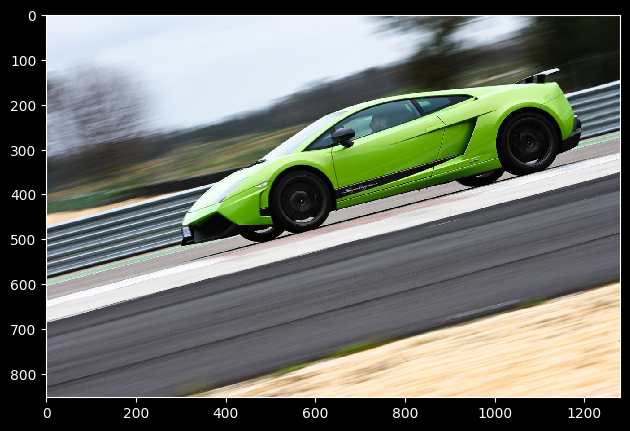

In [6]:
import random
import skimage
image_idx = random.randint(0, df.shape[0])
image = skimage.io.imread(df.path[image_idx])
skimage.io.imshow(image)

In [7]:
from oml.transforms.images.albumentations.transforms import get_augs_albu, get_normalisation_resize_albu

In [8]:
# train
train_dataset = DatasetWithLabels(df_train, dataset_root=dataset_root, transform=get_augs_albu(im_size=224))
batch_sampler = BalanceSampler(train_dataset.get_labels(), n_labels=2, n_instances=10)
train_loader = DataLoader(train_dataset, batch_sampler=batch_sampler)

# val
val_dataset = DatasetQueryGallery(df_val, dataset_root=dataset_root, transform=get_normalisation_resize_albu(im_size=224))
val_loader = DataLoader(val_dataset, batch_size=64)

In [9]:
next(iter(train_loader))['input_tensors'].shape

torch.Size([20, 3, 224, 224])

In [10]:
from src.hyper_triplet import HypTripletLossWithMiner

In [14]:
# model
# model = ResnetExtractor('resnet50_moco_v2', arch='resnet50', normalise_features=False, remove_fc=True, gem_p=1)
model = ViTExtractor('vits8_dino', arch='vits8', normalise_features=False)
# model = torch.compile(model)

# run
criterion = HypTripletLossWithMiner(c=0.2, margin=0.1, miner=HardTripletsMiner())
metric_callback = MetricValCallback(
    metric=EmbeddingMetrics(
        cmc_top_k=(1,5), 
    )
)
optimizer = Adam(model.parameters(), lr=1e-4)

pl_model = RetrievalModule(model, criterion, optimizer)
trainer = Trainer(
    max_epochs=100,
    # logger=logger,
    callbacks=[metric_callback],
    num_sanity_val_steps=0,
    accumulate_grad_batches=10,
    accelerator='cpu', 
    precision=16
)

https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_pretrain/dino_deitsmall8_pretrain.pth


d:\Repositories\metric-learning\.venv\lib\site-packages\lightning_fabric\connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
d:\Repositories\metric-learning\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:509: UserWarning: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Checkpoint is already here.


d:\Repositories\metric-learning\.venv\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [15]:
trainer.fit(pl_model, train_dataloaders=train_loader, val_dataloaders=val_loader)


  | Name      | Type                    | Params
------------------------------------------------------
0 | model     | ViTExtractor            | 21.7 M
1 | criterion | HypTripletLossWithMiner | 1     
------------------------------------------------------
21.7 M    Trainable params
0         Non-trainable params
21.7 M    Total params
86.681    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

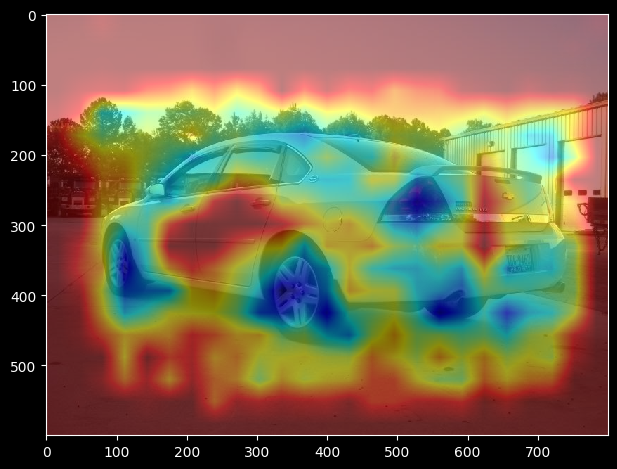

In [ ]:
skimage.io.imshow(model.draw_gradcam(image))

In [47]:
import gc
torch.cuda.empty_cache()
gc.collect()

15138